In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [12]:
from surrogate_model_training_data import get_data

**Purpose of this notebook**

In this Jupyter Notebook we obtain the full datasets for training our deep learning models. We train and export the model, which is then used for the control task.
The data pre-processing is extensively studied and described in `dnn_surrogate_prototyping.ipynb`. The developed method was then outsourced to the python script `surrogate_model_training_data.py`. 

# Get Network Information
We load the `.inp` file within the user defined class `testWN` and populate:
```
testWN.wn = wntr.network.WaterNetworkModel(self.__filePath)
```
The class adds some convenience features that act directly on the network, such as:
```
[tank_names, reservoir_names, junction_names] = ctown.getNodeName()
[pump_names, pipe_names, valve_names] = ctown.getLinkName()
```
These names are used throughout this script.

In [6]:
inp_file = '../../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [7]:
cluster_label_path = '../../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_25cl.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_25cl.json')
n_clusters = 25

## Data pre-processing
We process data from different sources for the surrogate model (similarly for clustering). Data was created with:
- Random control inputs
- Standard rule based control with random demand patterns
- MPC control with various surrogate models and clustering patterns

Each data source has their individual advantages and disadvantages.

**Random control inputs:** Result in a very diverse excitement of the system using the control inputs to their full extend. The system is occasionally operating in an unphysical range. 

**Standard rule based control:** The system operates in the desired range. However, controls are not continous and only a limited section of the state-space is explored.

**MPC control:** The system operates in the desired range. Controls are continous. Training data is limited. No training data was available, initially.

Over the course of the project this script was therefore evaluated multiple times with different sources and compositions of data. In the section below we load the different sources and define a composition.


**Note**: The `data_path` variables below must be adapted.

**Filtering**

All results files are filtered according to the preferences below:

In [8]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-100).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=-10).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Pump is not active below these pump speeds. It is not beneficial to learn this discontinuitiy.
    # We set the same values as minimum in the controller setup and filter out all training samples outside the range.
    min_pump_setting = np.array([0.34, 0.64, 0.64, 0.54, 0.54]).reshape(1,-1)
    
    f_4 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4
    return f

### with random control input:

In [15]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input_rc.shape, nn_output_rc.shape[1]))

n_samples=100800, n_inputs = 41, n_outputs=37


In [33]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
print('After filtering:')
print('n_samples={}'.format(nn_input_rc_filtered.shape[0]))

After filtering:
n_samples=7820


### without random control input:

In [20]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input_nc.shape, nn_output_nc.shape[1]))

n_samples=100800, n_inputs = 41, n_outputs=37


In [21]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [34]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
print('After filtering:')
print('n_samples={}'.format(nn_input_nc_filtered.shape[0]))

After filtering:
n_samples=100800


In [35]:
n_data_nc = 2000
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
print('After sampling+filtering:')
print('n_samples={}'.format(nn_input_nc_sampled.shape[0]))

After sampling+filtering:
n_samples=2000


### From previous MPC solutions

In [29]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input_mpc.shape, nn_input_mpc.shape[1]))

n_samples=19917, n_inputs = 41, n_outputs=41


In [30]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]
print('After filtering:')
print('n_samples={}'.format(nn_input_mpc.shape[0]))

After filtering:
n_samples=19917


## Concatenate everything:

In [45]:
nn_input =  pd.concat((
    nn_input_rc_filtered,
    nn_input_nc_sampled,
    nn_input_mpc_filtered
), axis=0)
nn_output = pd.concat((
    nn_output_rc_filtered, 
    nn_output_nc_sampled, 
    nn_output_mpc_filtered
), axis=0)

print('Concatenated dataset:')
print('n_samples={}'.format(nn_input.shape[0]))

Concatenated dataset:
n_samples=26911


### Normalize Data:

In [46]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.max()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

In [47]:
output_scaling

sys_states   tank_press         T3        1.909939
                                T1        0.967890
                                T7        3.457603
                                T6        2.245026
                                T5        2.195420
                                T2        1.697766
                                T4        3.272795
aux_outputs  pump_energy        PU2     540.622321
                                PU5     234.077679
                                PU6     407.726250
                                PU8     233.431295
                                PU10    177.243103
             jun_cl_press_mean  0         5.351577
                                1        27.165466
                                2         4.405117
                                3         4.763760
                                4         5.464354
                                5         5.270251
                                6         3.985655
                               

### Train / Test Splitting

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [49]:
X_train.shape

(21528, 41)

# Neural Network

## Create Model

In [51]:
n_layer = 4          
n_units = 50         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2100      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 37)                1887      
Total params: 11,637
Trainable params: 11,637
Non-trainable params: 0
_______________________________________________________

## Train model

In [52]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [53]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=1000, 
                    epochs=50,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),)
                    #callbacks=[callback])

Train on 21528 samples, validate on 5383 samples
Epoch 1/50
21528/21528 [==============================] - 1s 65us/sample - loss: 0.0515 - val_loss: 0.0284
Epoch 2/50
21528/21528 [==============================] - 0s 13us/sample - loss: 0.0249 - val_loss: 0.0221
Epoch 3/50
21528/21528 [==============================] - 0s 12us/sample - loss: 0.0206 - val_loss: 0.0191
Epoch 4/50
21528/21528 [==============================] - 0s 13us/sample - loss: 0.0181 - val_loss: 0.0170
Epoch 5/50
21528/21528 [==============================] - 0s 13us/sample - loss: 0.0162 - val_loss: 0.0154
Epoch 6/50
21528/21528 [==============================] - 0s 14us/sample - loss: 0.0148 - val_loss: 0.0141
Epoch 7/50
21528/21528 [==============================] - 0s 13us/sample - loss: 0.0136 - val_loss: 0.0130
Epoch 8/50
21528/21528 [==============================] - 0s 10us/sample - loss: 0.0126 - val_loss: 0.0121
Epoch 9/50
21528/21528 [==============================] - 0s 10us/sample - loss: 0.0117 - val_l

Save model:

In [24]:
model_path = './models/'
model_name = '018_man_4x50_25cl'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [25]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [68]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [69]:
val_i = -1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [70]:
for k in range(50):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<IPython.core.display.Javascript object>


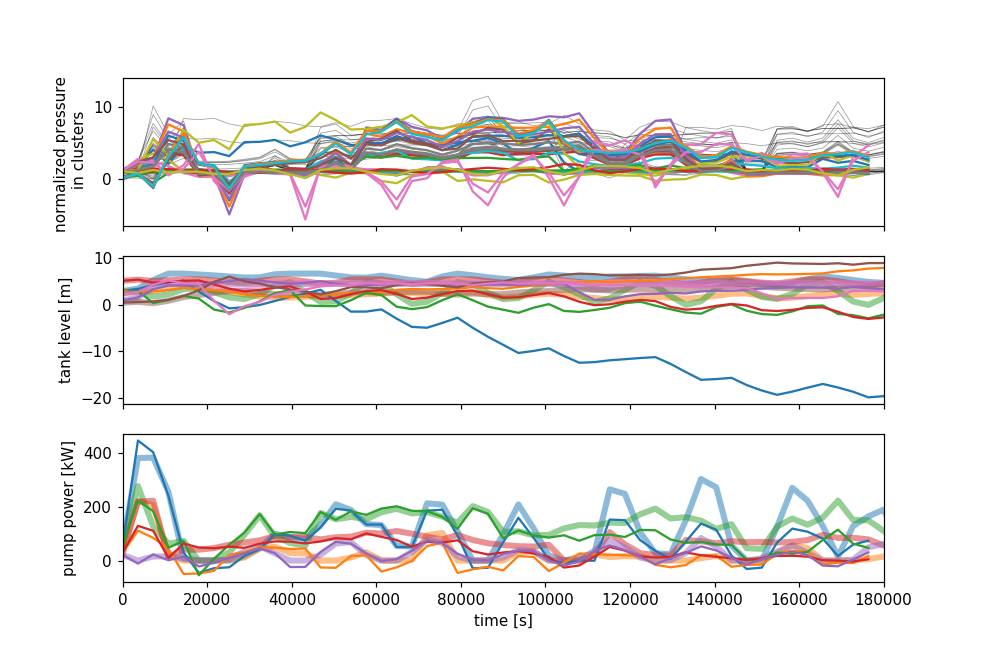

Text(0.5, 0, 'time [s]')

In [71]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [77]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [78]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [81]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


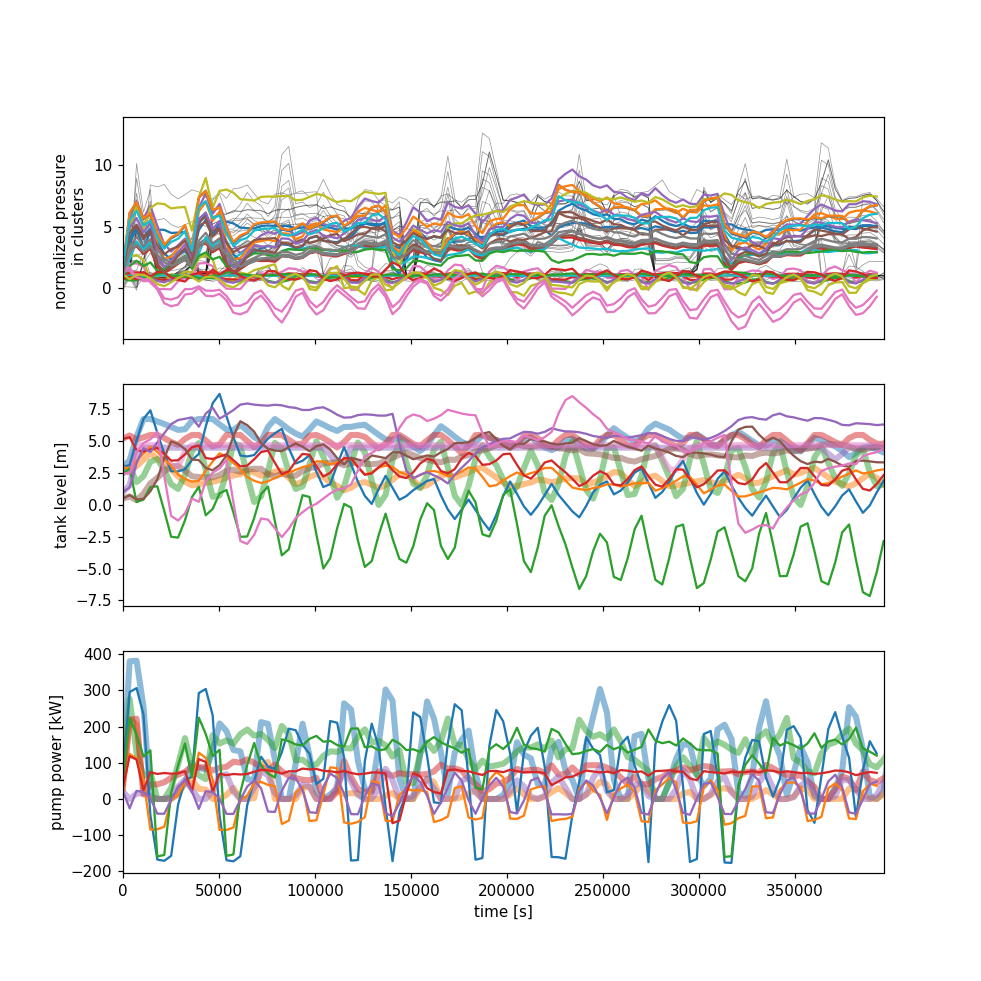

Text(0.5, 0, 'time [s]')

In [82]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

## Score of linear model:

In [88]:
np.sum((linear_reg.predict(X_train)-Y_train.to_numpy())**2)/X_train.size

0.003670537913622774